In [5]:
# import packages
import open3d as o3d
import pandas as pd
import numpy as np

In [6]:
# Load your CSV
df = pd.read_csv("/home/raychen/VR_Interface/XR-Course/ARPL-test/pointCloud-render/pointCloud_structured.csv")
points = df[['x', 'y', 'z']].values

In [7]:
# Create point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

In [33]:
# Ball Pivoting Algorithm
print("Starting Ball Pivoting Algorithm...")
print(f"Input point cloud: {len(pcd.points)} points")

# Step 1: Estimate normals (crucial for BPA)
print("1. Estimating normals...")
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

# Step 2: Calculate optimal ball radii
print("2. Calculating optimal ball radii...")
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)

radii = [
    avg_dist * 0.05,
    avg_dist * 0.1,
    avg_dist * 0.3,
    avg_dist * 0.5,
    avg_dist * 0.8,
    avg_dist * 1.5,     # Fine details
    avg_dist * 2.0,     # Medium details  
    avg_dist * 3.0,     # Coarse details
    avg_dist * 4.0,      # Fill large gaps
    avg_dist * 5.0,
    avg_dist * 6.0,
    avg_dist * 7.0,
    avg_dist * 8.0
]

print(f"   Average distance: {avg_dist:.4f}")
print(f"   Using radii: {[f'{r:.4f}' for r in radii]}")

# Step 3: Apply Ball Pivoting Algorithm
print("3. Applying Ball Pivoting Algorithm...")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, 
    o3d.utility.DoubleVector(radii)
)

print(f"   Generated mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

# Step 4: Clean up mesh
print("4. Cleaning up mesh...")
mesh.remove_degenerate_triangles()
mesh.remove_duplicated_triangles()
mesh.remove_duplicated_vertices()
mesh.remove_non_manifold_edges()
mesh.compute_vertex_normals()

print(f"   Final mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

Starting Ball Pivoting Algorithm...
Input point cloud: 1130 points
1. Estimating normals...
2. Calculating optimal ball radii...
   Average distance: 0.1596
   Using radii: ['0.0080', '0.0160', '0.0479', '0.0798', '0.1277', '0.2394', '0.3192', '0.4789', '0.6385', '0.7981', '0.9577', '1.1173', '1.2769']
3. Applying Ball Pivoting Algorithm...
   Generated mesh: 1130 vertices, 1331 triangles
4. Cleaning up mesh...
   Final mesh: 1130 vertices, 1331 triangles


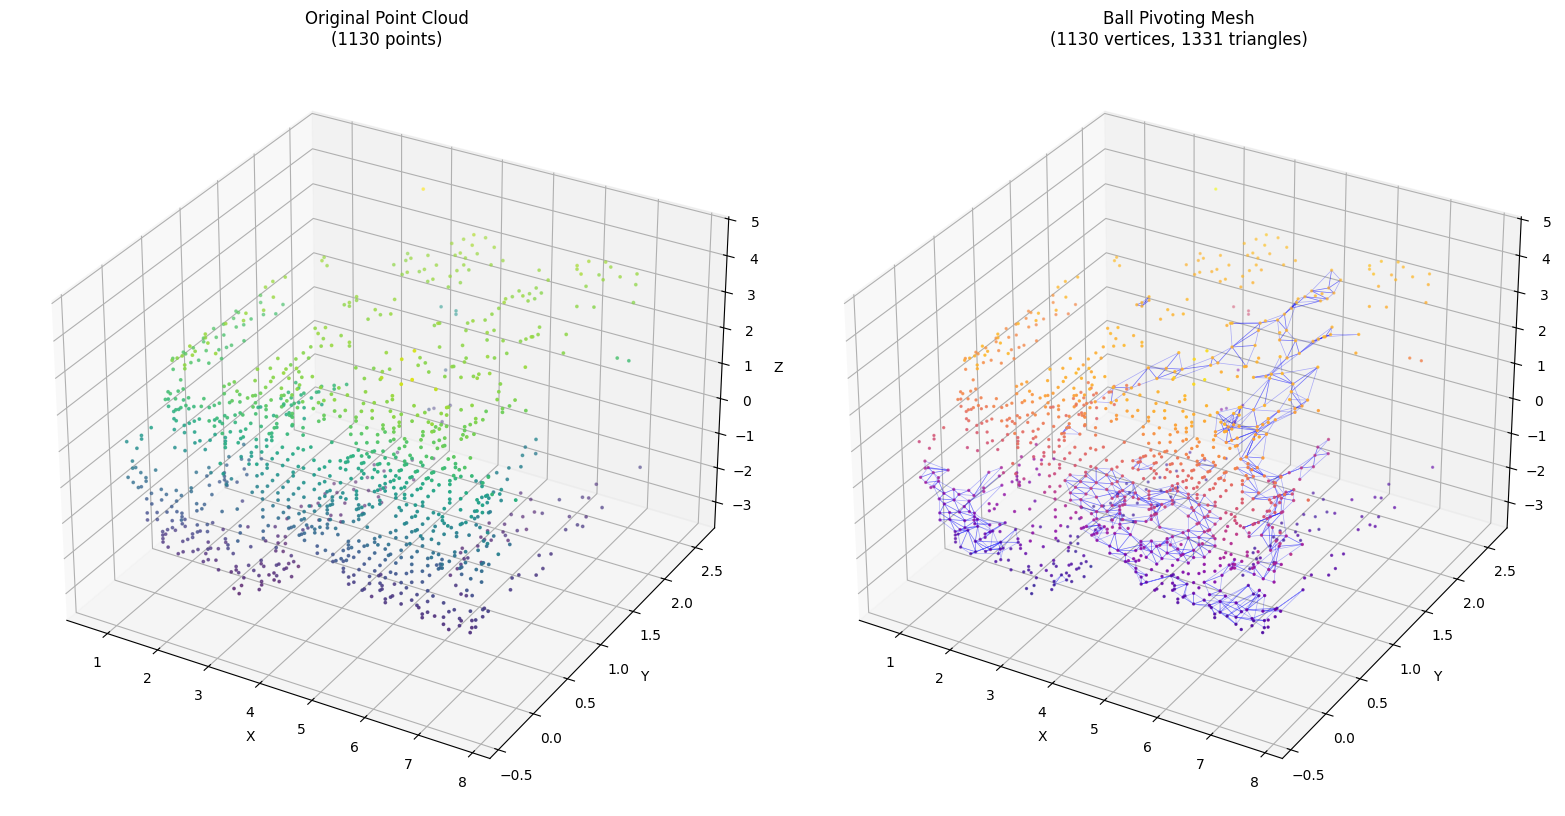

✅ Ball Pivoting completed! Mesh has 1331 triangles

Mesh Quality:
  Original points: 1130
  Mesh vertices: 1130
  Triangles: 1331
  Coverage: 100.0%
  Watertight: False


In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract data
points = np.asarray(pcd.points)
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

# Create visualization
fig = plt.figure(figsize=(16, 8))

# Plot 1: Original Point Cloud
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(points[:, 0], points[:, 1], points[:, 2], 
                      c=points[:, 2], cmap='viridis', s=3)
ax1.set_title(f'Original Point Cloud\n({len(points)} points)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot 2: Ball Pivoting Mesh
ax2 = fig.add_subplot(122, projection='3d')

# Plot mesh wireframe
for i, triangle in enumerate(triangles[:500]):  # Limit for performance
    triangle_points = vertices[triangle]
    triangle_loop = np.vstack([triangle_points, triangle_points[0]])
    ax2.plot(triangle_loop[:, 0], triangle_loop[:, 1], triangle_loop[:, 2], 
            'b-', alpha=0.3, linewidth=0.5)

# Plot vertices
ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], 
           c=vertices[:, 2], cmap='plasma', s=2)

ax2.set_title(f'Ball Pivoting Mesh\n({len(vertices)} vertices, {len(triangles)} triangles)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

print(f"✅ Ball Pivoting completed! Mesh has {len(triangles)} triangles")

# Quality analysis
print(f"\nMesh Quality:")
print(f"  Original points: {len(points)}")
print(f"  Mesh vertices: {len(vertices)}")
print(f"  Triangles: {len(triangles)}")
print(f"  Coverage: {len(vertices)/len(points)*100:.1f}%")
print(f"  Watertight: {mesh.is_watertight()}")

# Poission Reconstruction

In [35]:

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

print("Starting Poisson Surface Reconstruction...")
print(f"Input point cloud: {len(pcd.points)} points")

# Step 1: Estimate normals
print("1. Estimating normals...")
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

# Step 2: Apply Poisson reconstruction
print("2. Applying Poisson reconstruction...")
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd, 
    depth=8,           
    width=0,           
    scale=1.05,        
    linear_fit=True    
)

print(f"   Generated mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

# Step 3: ESSENTIAL - Smart density filtering
if len(densities) > 0:
    print("3. Smart density filtering...")
    
    # Convert to numpy for analysis
    densities_np = np.asarray(densities)
    
    print(f"   Density range: {densities_np.min():.6f} to {densities_np.max():.6f}")
    print(f"   Density mean: {densities_np.mean():.6f}")
    
    # Strategy 1: Remove only bottom 2-5% (very conservative)
    density_threshold = np.quantile(densities_np, 0.02)  # Only remove bottom 2%
    vertices_to_remove = densities_np < density_threshold
    
    print(f"   Removing {np.sum(vertices_to_remove)} low-density vertices ({np.sum(vertices_to_remove)/len(densities_np)*100:.1f}%)")
    print(f"   Keeping {np.sum(~vertices_to_remove)} vertices ({np.sum(~vertices_to_remove)/len(densities_np)*100:.1f}%)")
    
    mesh.remove_vertices_by_mask(vertices_to_remove)
    print(f"   After filtering: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

# Step 4: Gentle cleanup (less aggressive)
print("4. Gentle cleanup...")
initial_vertices = len(mesh.vertices)
initial_triangles = len(mesh.triangles)

# Only essential cleanup
mesh.remove_degenerate_triangles()
mesh.compute_vertex_normals()

# Skip aggressive cleanup that removes too much:
# mesh.remove_duplicated_triangles()  # Can remove valid triangles
# mesh.remove_duplicated_vertices()   # Can remove valid vertices
# mesh.remove_non_manifold_edges()    # Can remove valid geometry

final_vertices = len(mesh.vertices)
final_triangles = len(mesh.triangles)

print(f"   Cleanup removed: {initial_vertices - final_vertices} vertices, {initial_triangles - final_triangles} triangles")
print(f"   Final mesh: {final_vertices} vertices, {final_triangles} triangles")

# Step 5: Coverage analysis
coverage_ratio = final_vertices / len(pcd.points)
print(f"\nCoverage Analysis:")
print(f"   Input points: {len(pcd.points)}")
print(f"   Output vertices: {final_vertices}")
print(f"   Expansion ratio: {coverage_ratio:.1f}x")

if coverage_ratio < 3:
    print("   ⚠️ Low vertex count - try depth=9 or smaller density threshold")
elif coverage_ratio > 20:
    print("   ⚠️ High vertex count - try depth=7 or larger density threshold")
else:
    print("   ✅ Good vertex count")


Starting Poisson Surface Reconstruction...
Input point cloud: 1130 points
1. Estimating normals...
2. Applying Poisson reconstruction...
   Generated mesh: 4370 vertices, 8504 triangles
3. Smart density filtering...
   Density range: 2.019348 to 5.508851
   Density mean: 4.421328
   Removing 88 low-density vertices (2.0%)
   Keeping 4282 vertices (98.0%)
   After filtering: 4282 vertices, 8343 triangles
4. Gentle cleanup...
   Cleanup removed: 0 vertices, 0 triangles
   Final mesh: 4282 vertices, 8343 triangles

Coverage Analysis:
   Input points: 1130
   Output vertices: 4282
   Expansion ratio: 3.8x
   ✅ Good vertex count


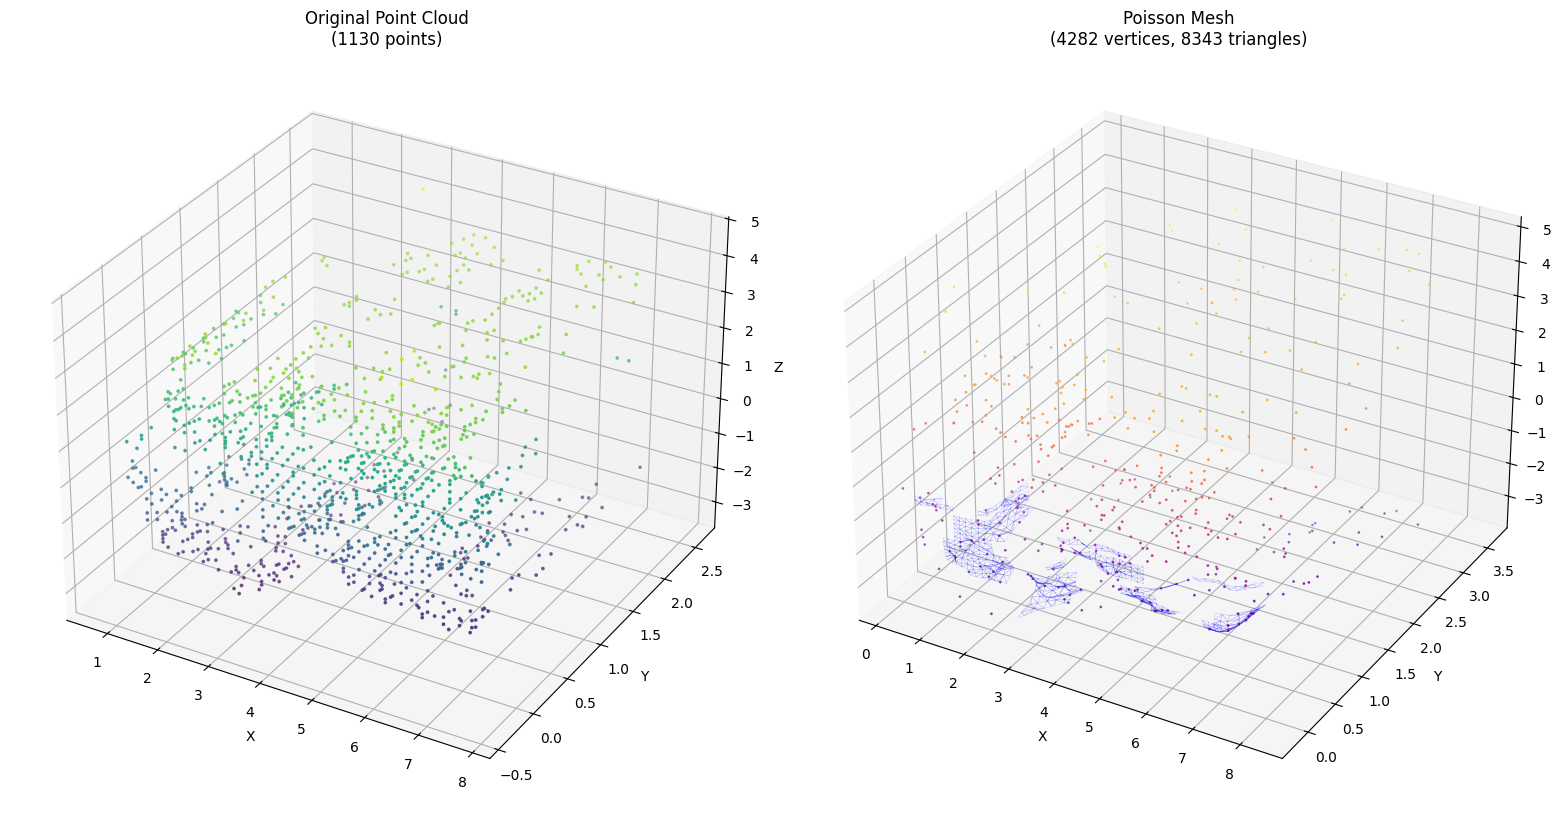

✅ Poisson reconstruction completed!

Mesh Quality:
  Original points: 1130
  Mesh vertices: 4282
  Triangles: 8343
  Watertight: False
  Orientable: True
  Point cloud bounds: [ 0.69999999 -0.40000001 -3.20000005] to [7.80000019 2.60000014 4.5       ]
  Mesh bounds: [ 0.20750046 -0.24093747 -3.39249969] to [8.29249954 3.7130599  4.69249916]


In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract data
points = np.asarray(pcd.points)
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

# Create visualization
fig = plt.figure(figsize=(16, 8))

# Plot 1: Original Point Cloud
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(points[:, 0], points[:, 1], points[:, 2], 
                      c=points[:, 2], cmap='viridis', s=3)
ax1.set_title(f'Original Point Cloud\n({len(points)} points)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot 2: Poisson Mesh
ax2 = fig.add_subplot(122, projection='3d')

# Plot mesh surface (sample triangles for performance)
max_triangles = min(1000, len(triangles))  # Limit for visualization
sample_triangles = triangles[:max_triangles]

for triangle in sample_triangles:
    triangle_points = vertices[triangle]
    triangle_loop = np.vstack([triangle_points, triangle_points[0]])
    ax2.plot(triangle_loop[:, 0], triangle_loop[:, 1], triangle_loop[:, 2], 
            'b-', alpha=0.2, linewidth=0.3)

# Plot vertices
ax2.scatter(vertices[::10, 0], vertices[::10, 1], vertices[::10, 2], 
           c=vertices[::10, 2], cmap='plasma', s=1)

ax2.set_title(f'Poisson Mesh\n({len(vertices)} vertices, {len(triangles)} triangles)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

print(f"✅ Poisson reconstruction completed!")

# Quality analysis
print(f"\nMesh Quality:")
print(f"  Original points: {len(points)}")
print(f"  Mesh vertices: {len(vertices)}")
print(f"  Triangles: {len(triangles)}")
print(f"  Watertight: {mesh.is_watertight()}")
print(f"  Orientable: {mesh.is_orientable()}")

# Check if mesh bounds match point cloud
points_bbox = [points.min(axis=0), points.max(axis=0)]
vertices_bbox = [vertices.min(axis=0), vertices.max(axis=0)]
print(f"  Point cloud bounds: {points_bbox[0]} to {points_bbox[1]}")
print(f"  Mesh bounds: {vertices_bbox[0]} to {vertices_bbox[1]}")

# Aplha shapes

In [37]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

print("Starting Alpha Shapes Reconstruction...")
print(f"Input point cloud: {len(pcd.points)} points")

# Step 1: Estimate normals
print("1. Estimating normals...")
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

# Step 2: Calculate optimal alpha value
print("2. Calculating optimal alpha...")
distances = pcd.compute_nearest_neighbor_distance()
distances_np = np.asarray(distances)

# Alpha should be related to point spacing
avg_dist = np.mean(distances_np)
median_dist = np.median(distances_np)

# Good starting alpha values
suggested_alpha = avg_dist * 2.0  # Common heuristic

print(f"   Average distance: {avg_dist:.4f}")
print(f"   Median distance: {median_dist:.4f}")
print(f"   Suggested alpha: {suggested_alpha:.4f}")

# Step 3: Try different alpha values
alpha_values = [
    avg_dist * 0.5,   # Very tight (may create holes)
    avg_dist * 1.0,   # Tight
    avg_dist * 2.0,   # Balanced (recommended)
    avg_dist * 3.0,   # Loose
    avg_dist * 5.0,   # Very loose
]

print(f"3. Testing alpha values...")

best_alpha = None
best_mesh = None
best_score = 0

for alpha in alpha_values:
    print(f"\n--- Testing alpha = {alpha:.4f} ---")
    
    # Create alpha shape mesh
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
    mesh.compute_vertex_normals()
    
    num_vertices = len(mesh.vertices)
    num_triangles = len(mesh.triangles)
    
    print(f"   Vertices: {num_vertices}")
    print(f"   Triangles: {num_triangles}")
    
    # Check if mesh preserves original points
    vertices_np = np.asarray(mesh.vertices)
    points_np = np.asarray(pcd.points)
    
    if len(vertices_np) == len(points_np):
        print("   ✅ Preserves all original points!")
        point_preservation = 1.0
    else:
        print(f"   ⚠️ Point count changed: {len(vertices_np)} vs {len(points_np)}")
        point_preservation = min(len(vertices_np), len(points_np)) / max(len(vertices_np), len(points_np))
    
    # Simple scoring: prefer meshes with good triangle count and point preservation
    if num_triangles > 0:
        score = point_preservation * min(num_triangles / 1000, 1.0)  # Normalize triangle count
        print(f"   Score: {score:.3f}")
        
        if score > best_score:
            best_score = score
            best_alpha = alpha
            best_mesh = mesh
    else:
        print("   ❌ No triangles generated")

# Step 4: Use best alpha or default
if best_mesh is not None:
    print(f"\n✅ Best alpha: {best_alpha:.4f} (score: {best_score:.3f})")
    mesh = best_mesh
else:
    print(f"\n⚠️ No good alpha found, using default: {suggested_alpha:.4f}")
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, suggested_alpha)
    mesh.compute_vertex_normals()

print(f"Final Alpha Shape: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

Starting Alpha Shapes Reconstruction...
Input point cloud: 1130 points
1. Estimating normals...
2. Calculating optimal alpha...
   Average distance: 0.1596
   Median distance: 0.1414
   Suggested alpha: 0.3192
3. Testing alpha values...

--- Testing alpha = 0.0798 ---
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloud

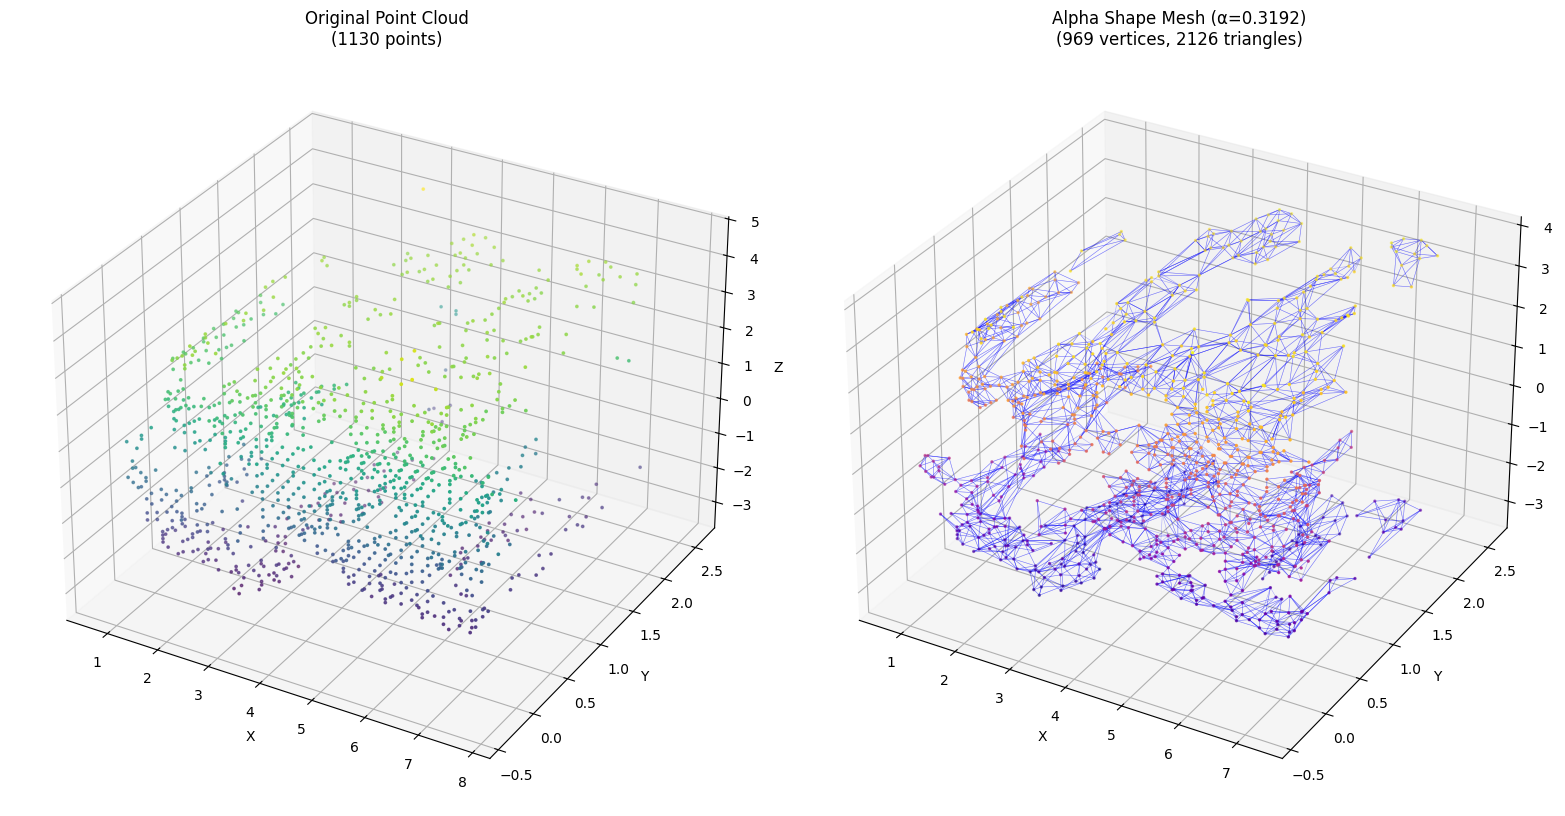


Alpha Shape Quality Analysis:
  Input points: 1130
  Output vertices: 969
  Output triangles: 2126
  ⚠️ Point count difference: 161
  Watertight: False
  Orientable: False


In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract data
points_np = np.asarray(pcd.points)
vertices_np = np.asarray(mesh.vertices)
triangles_np = np.asarray(mesh.triangles)

# Create visualization
fig = plt.figure(figsize=(16, 8))

# Plot 1: Original Point Cloud
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], 
                      c=points_np[:, 2], cmap='viridis', s=3)
ax1.set_title(f'Original Point Cloud\n({len(points_np)} points)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plot 2: Alpha Shape Mesh
ax2 = fig.add_subplot(122, projection='3d')

# Plot mesh wireframe (limit for performance)
max_triangles_to_plot = min(2000, len(triangles_np))
sample_triangles = triangles_np[:max_triangles_to_plot]

for triangle in sample_triangles:
    triangle_points = vertices_np[triangle]
    triangle_loop = np.vstack([triangle_points, triangle_points[0]])
    ax2.plot(triangle_loop[:, 0], triangle_loop[:, 1], triangle_loop[:, 2], 
            'b-', alpha=0.3, linewidth=0.4)

# Plot vertices
ax2.scatter(vertices_np[:, 0], vertices_np[:, 1], vertices_np[:, 2], 
           c=vertices_np[:, 2], cmap='plasma', s=2)

ax2.set_title(f'Alpha Shape Mesh (α={best_alpha:.4f})\n({len(vertices_np)} vertices, {len(triangles_np)} triangles)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

# Step 7: Quality analysis
print(f"\nAlpha Shape Quality Analysis:")
print(f"  Input points: {len(points_np)}")
print(f"  Output vertices: {len(vertices_np)}")
print(f"  Output triangles: {len(triangles_np)}")

if len(vertices_np) == len(points_np):
    print("  ✅ Perfect point preservation!")
else:
    print(f"  ⚠️ Point count difference: {abs(len(vertices_np) - len(points_np))}")

print(f"  Watertight: {mesh.is_watertight()}")
print(f"  Orientable: {mesh.is_orientable()}")